In [1]:
import scipy as sp
import numpy as np
import os 
import pickle

import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime

from architectures.cycleGAN import *

In [2]:
import tensorflow as tf
tf.__version__

'1.4.1'

In [3]:
# some constants

LEARNING_RATE_D = 0.0001
LEARNING_RATE_G = 0.0001
BETA1 = 0.5
BATCH_SIZE = 5
EPOCHS = 1
SAVE_SAMPLE_PERIOD = 5
task='TRAIN'
#task='TEST'
SEED=1

PATH = 'cycleGAN_test'

In [4]:
trunc_normal= tf.truncated_normal_initializer(stddev=0.02)
normal = tf.random_normal_initializer(stddev=0.02)

uniform = tf.random_uniform_initializer()
glorot_uniform = tf.glorot_uniform_initializer()
glorot_normal = tf.glorot_normal_initializer()

global d_sizes, g_sizes

d_sizes_A = {
         'conv_layers': [(2, 6, 2, False, 1, lrelu, trunc_normal),
                         (32, 6, 2, False, 1, lrelu, trunc_normal)],
         'dense_layers': [(512, True, 1, lrelu ,trunc_normal)],
         'readout_layer_w_init':normal,
}

d_sizes_B = {
         'conv_layers': [(2, 6, 2, False, 1, lrelu, trunc_normal),
                         (32, 6, 2, False, 1, lrelu, trunc_normal)],
         'dense_layers': [(512, True, 1, lrelu ,trunc_normal)],
         'readout_layer_w_init':normal,
}

g_sizes_A={
         'conv_layer_0':[(3, 8, 2, False, 1, tf.nn.relu, glorot_normal)],
         'conv_layer_1':[(16, 6, 2, False, 1, tf.nn.relu, glorot_normal)],
         'convblock_layer_0':[(32, 4, 2, True, 1, tf.nn.relu, glorot_normal),
                                (32, 4, 1, False, 1, tf.nn.relu, glorot_normal),
                                (32, 4, 2, True, 1, tf.nn.relu, glorot_normal)],
         'convblock_shortcut_layer_0':[(32, 1, 4, False, 1, glorot_normal)],
         'deconv_layer_0':[(16, 6, 2, False, 1, tf.nn.relu, glorot_normal)],
         'deconv_layer_1':[(3, 8, 2, False, 1, tf.nn.relu, glorot_normal)],
         
        
}

g_sizes_B={
         'conv_layer_0':[(3, 8, 2, False, 1, tf.nn.relu, glorot_normal)],
         'conv_layer_1':[(16, 6, 2, False, 1, tf.nn.relu, glorot_normal)],
         'convblock_layer_0':[(32, 4, 2, True, 1, tf.nn.relu, glorot_normal),
                                (32, 4, 1, False, 1, tf.nn.relu, glorot_normal),
                                (32, 4, 2, True, 1, tf.nn.relu, glorot_normal)],
         'convblock_shortcut_layer_0':[(32, 1, 4, False, 1, glorot_normal)],
         'deconv_layer_0':[(16, 6, 2, False, 1, tf.nn.relu, glorot_normal)],
         'deconv_layer_1':[(3, 8, 2, False, 1, tf.nn.relu, glorot_normal)],
         
         
}

In [5]:
def Horse2Zebra():
    
    train_A = np.array(
    [plt.imread("horse2zebra/trainA/"+filename) for filename in os.listdir("horse2zebra/trainA")]
    )
    
    train_B = np.array(
    [plt.imread("./horse2zebra/trainB/"+filename) for filename in os.listdir("./horse2zebra/trainB")]
    )
    
    m = np.minimum(train_A.shape[0],train_B.shape[0])
    
    _, n_H, n_W, n_C = train_A.shape
    
    X_train_A = train_A[0:m]
    X_train_B = train_B[0:m]
    
    train_A=train_A.astype(np.float32)
    mean_A=np.mean(train_A,axis=0)
    train_A-=mean_A
    std_A=np.std(train_A,axis=0)
    train_A/=std_A
    
    train_B=train_B.astype(np.float32)
    mean_B=np.mean(train_B,axis=0)
    train_B-=mean_B
    std_B=np.std(train_B,axis=0)
    train_B/=std_B
    
    tf.reset_default_graph()

    gan = cycleGAN(n_H, n_W, n_C, mean_A, std_A, mean_B, std_B, d_sizes_A, d_sizes_B, g_sizes_A, g_sizes_B,
                   lr_g=LEARNING_RATE_G, lr_d=LEARNING_RATE_D,beta1=BETA1,
                  batch_size=BATCH_SIZE, epochs=EPOCHS,
                  save_sample=SAVE_SAMPLE_PERIOD, path=PATH, seed=SEED)
    
    vars_to_train= tf.trainable_variables()
    
    if task == 'TRAIN':
        init_op = tf.global_variables_initializer()
        
    if task == 'TEST':
        vars_all = tf.global_variables()
        vars_to_init = list(set(vars_all)-set(vars_to_train))
        init_op = tf.variables_initializer(vars_to_init)
        
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()    
        
    with tf.Session() as sess:
        
        sess.run(init_op)

        if task=='TRAIN':
            print('\n Training...')
            
            if os.path.exists(PATH+'/'+PATH+'.ckpt.index'):
                saver.restore(sess,PATH+'/'+PATH+'.ckpt')
                print('Model restored.')
            
            gan.set_session(sess)
            gan.fit(X_train_A, X_train_B)
            
            save_path = saver.save(sess, PATH+'/'+PATH+'.ckpt')
            print("Model saved in path: %s" % save_path)
        
        if task=='TEST':
            print('\n Evaluate model on test set...')
            saver.restore(sess,PATH+'/'+PATH+'.ckpt')
            print('Model restored.')
            
            gan.set_session(sess) 
            
        done = True
        while not done:
            
            
            j = np.random.choice(len(X_train_A))
            true_img = X_train_A[j]
            sample_img = gan.get_sample(true_img)
            
            plt.subplot(1,2,1)
            plt.imshow(true_img.reshape(n_H,n_W),cmap='gray')
            plt.subplot(1,2,2)
            plt.imshow(sample_img.reshape(n_H,n_W),cmap='gray')
            
            fig=plt.gcf()
            fig.set_size_inches(5,8)
            plt.savefig(PATH+'/sample_{0}_at_iter_{1}.png'.format(j, total_iters),dpi=300)
            
            ans = input("Generate another?")
            if ans and ans[0] in ('n' or 'N'):
                done = True

Convolutional Network architecture detected
Convolutional Network architecture detected
Discriminator_A
Convolution
Input for convolution shape  (?, 256, 256, 3)
(131072, 512)
Logits shape (?, 1)
Generator_A_to_B
Input for deconvolution shape (?, 256, 256, 3)
Deconvoluted output shape (?, 256, 256, 3)
Discriminator_B
Convolution
Input for convolution shape  (?, 256, 256, 3)
(131072, 512)
Logits shape (?, 1)
Generator_B_to_A
Input for deconvolution shape (?, 256, 256, 3)
Deconvoluted output shape (?, 256, 256, 3)
Discriminator_A
Convolution
Input for convolution shape  (?, 256, 256, 3)
(131072, 512)
Logits shape (?, 1)
Discriminator_B
Convolution
Input for convolution shape  (?, 256, 256, 3)
(131072, 512)
Logits shape (?, 1)
Generator_A_to_B
Input for deconvolution shape (?, 256, 256, 3)
Deconvoluted output shape (?, 256, 256, 3)
Generator_B_to_A
Input for deconvolution shape (?, 256, 256, 3)
Deconvoluted output shape (?, 256, 256, 3)
Generator_A_to_B
Input for deconvolution shape (?, 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


At iter: 5  -  dt: 0:00:00.663926 - d_acc_A: 0.30
At iter: 5  -  dt: 0:00:00.664032 - d_acc_B: 0.30
Discrimator_A cost 1.4195711612701416, Generator_A_to_B cost 18751.806640625
Discrimator_B cost 1.3885574340820312, Generator_B_to_A cost 21973.892578125
Saving a sample...
(256, 256, 3)
[[[10328 12793 17454]
  [ 9628 12080 16695]
  [ 9695 12072 16902]
  ...
  [ 7833  8644 12364]
  [ 7722  8532 12225]
  [ 7766  8608 12305]]

 [[ 9742 12386 17376]
  [ 9127 11740 16674]
  [ 9142 11781 16696]
  ...
  [ 7521  8447 12167]
  [ 7599  8554 12264]
  [ 7605  8584 12293]]

 [[ 9385 12267 17388]
  [ 8896 11743 16756]
  [ 8922 11785 16769]
  ...
  [ 7393  8337 12050]
  [ 7455  8402 12171]
  [ 7560  8517 12263]]

 ...

 [[11682  7599  5592]
  [11179  8509  6505]
  [10101  6899  5017]
  ...
  [10246  7223  5505]
  [10204  7200  5396]
  [10368  7160  5164]]

 [[11109  7695  5385]
  [ 8651  5963  3061]
  [10082  6524  3979]
  ...
  [10646  7307  5324]
  [10834  7365  5299]
  [10776  7165  5302]]

 [[ 984

/home/ttp/davide/miniconda3/envs/deepnet/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


At iter: 10  -  dt: 0:00:00.664300 - d_acc_A: 0.60
At iter: 10  -  dt: 0:00:00.664406 - d_acc_B: 0.40
Discrimator_A cost 1.3941705226898193, Generator_A_to_B cost 21842.125
Discrimator_B cost 1.401085376739502, Generator_B_to_A cost 15774.7001953125
Saving a sample...
(256, 256, 3)
[[[17706 17613 19926]
  [17732 17666 20257]
  [ 6510  6490  7455]
  ...
  [10120  9946 11973]
  [ 8342  8191  9966]
  [ 8668  8539 10345]]

 [[17327 17226 19509]
  [17560 17433 19978]
  [ 5981  5965  6817]
  ...
  [ 9844  9661 11627]
  [ 8842  8691 10478]
  [ 9194  9064 10892]]

 [[17866 17807 20247]
  [17515 17437 19982]
  [ 5697  5556  6422]
  ...
  [ 7460  7330  8980]
  [ 6772  6644  8216]
  [ 7422  7292  8925]]

 ...

 [[16139 15312 15757]
  [15695 14957 15614]
  [15632 14954 15639]
  ...
  [12041 10510 11266]
  [10923  9577 10269]
  [ 9694  8342  8945]]

 [[16219 15323 15824]
  [15700 14865 15444]
  [15636 14799 15417]
  ...
  [11740 10284 11032]
  [10403  9025  9640]
  [ 8992  7757  8299]]

 [[16220 15

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


At iter: 15  -  dt: 0:00:00.663400 - d_acc_A: 0.30
At iter: 15  -  dt: 0:00:00.663499 - d_acc_B: 0.40
Discrimator_A cost 1.4015769958496094, Generator_A_to_B cost 12943.6611328125
Discrimator_B cost 1.394911289215088, Generator_B_to_A cost 18508.40625
Saving a sample...
(256, 256, 3)
[[[ 9695  9160  9639]
  [10529  9873 10758]
  [10526 10142 11186]
  ...
  [ 9843  9809 10094]
  [ 7239  6964  6773]
  [ 7420  6614  5954]]

 [[ 8699  7478  7973]
  [ 9818  9066  9672]
  [ 9966  9386  9875]
  ...
  [ 8067  7705  7854]
  [ 9809  9306  9624]
  [10370  9407 10191]]

 [[ 8551  7143  7617]
  [ 6897  6187  6289]
  [ 9059  8636  8773]
  ...
  [11595 11222 12127]
  [10464 10093 10853]
  [10308  9605 10555]]

 ...

 [[ 4463  4887  4531]
  [ 4405  4817  4536]
  [ 4509  4973  4833]
  ...
  [ 4621  4974  5085]
  [ 5108  5287  5216]
  [ 7242  7338  7298]]

 [[ 4485  4910  4568]
  [ 4361  4784  4478]
  [ 4649  5116  4963]
  ...
  [ 4629  4972  4960]
  [ 5237  5466  5177]
  [ 7577  7638  7626]]

 [[ 4232 

KeyboardInterrupt: 

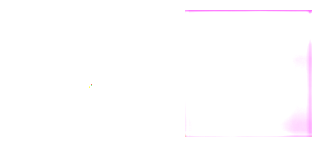

In [6]:
if __name__=='__main__':

    if task == 'TRAIN':
        if not os.path.exists(PATH):
            os.mkdir(PATH)
    
        elif os.path.exists(PATH):
            if os.path.exists(PATH+'/checkpoint'):
                ans = input('A previous checkpoint already exists, choose the action to perform \n \n 1) Overwrite the current model saved at '+PATH+'/checkpoint \n 2) Start training a new model \n 3) Restore and continue training the previous model \n ')
                
                if ans == '1':
                    print('Overwriting existing model in '+PATH)
                    for file in os.listdir(PATH):
                        file_path = os.path.join(PATH, file)
                        try:
                            if os.path.isfile(file_path):
                                os.unlink(file_path)
                            #elif os.path.isdir(file_path): shutil.rmtree(file_path)
                        except Exception as e:
                            print(e)
                            
                elif ans == '2':
                    PATH = input('Specify the name of the model, a new directory will be created.\n')
                    os.mkdir(PATH)    
        
        Horse2Zebra()
   
    elif task == 'TEST': 
        if not os.path.exists(PATH+'/checkpoint'):
            print('No checkpoint to test')
        else:
            Horse2Zebra()

In [ ]:
    train_A = np.array(
    [plt.imread("horse2zebra/trainA/"+filename) for filename in os.listdir("horse2zebra/trainA")]
    )
    
    train_B = np.array(
    [plt.imread("horse2zebra/trainB/"+filename) for filename in os.listdir("horse2zebra/trainB")]
    )
    
    m = np.minimum(train_A.shape[0],train_B.shape[0])
    
    _, n_H, n_W, n_C = train_A.shape
    

In [ ]:
    X_train_A = train_A[0:m]
    X_train_B = train_B[0:m]
    
    train_A=train_A.astype(np.float32)
    mean_A=np.mean(train_A,axis=0)
    train_A-=mean_A
    std_A=np.std(train_A,axis=0)
    train_A/=std_A
    
    train_B=train_B.astype(np.float32)
    mean_B=np.mean(train_B,axis=0)
    train_B-=mean_B
    std_B=np.std(train_B,axis=0)
    train_B/=std_B

In [ ]:
plt.imshow((train_A[0]*std_A+mean_A).astype(np.int32))

In [ ]:
plt.imshow((train_B[5]*std_B+mean_B).astype(np.int32))